## Interactive Helmholtz Resonator

### Author: Alex Fanomezantsoa Rabearivony
### ACOUSTIC METAMATERIAL BASED ON RECYCLED PLASTIC BOTTLES
### 2025

## Interactive Helmholtz Resonator — Impedance, Absorption & Transmission Loss

This interactive section models a **single Helmholtz resonator** (one bottle) as a **thin acoustic impedance sheet** between two identical half-spaces. The model includes a frequency-dependent viscous loss term and an optional user resistance. Results are computed on a high-resolution internal frequency grid (fixed), and the `fmax` widget only **controls the plotting window** (zoom), not the physical response.

---

### 1. Resonance frequency

The ideal (lossless) resonance frequency of a Helmholtz resonator with end correction is:

$$
f_{\mathrm{res}} \;=\; \frac{c}{2\pi}\sqrt{\frac{A}{V\,(L_{\mathrm{eff}})}}
\quad\text{with}\quad L_{\mathrm{eff}}=L+1.7\,r,
$$

where $c$ is the speed of sound, $A=\pi r^{2}$ the neck area, $V$ the cavity volume, $L$ the neck length and $r$ the neck radius. The end-correction $1.7\,r$ accounts approximately for the extra air mass at the neck opening.

---

### 2. Viscous loss model and resonator impedance

A simple estimate of viscous boundary-layer effects in the neck is used:

$$
\delta(f)=\sqrt{\frac{2\mu}{\rho_0\,\omega}},\qquad
R_{\mathrm{viscous}}(f)\approx Z_0\,\frac{2\delta(f)}{r},
$$

with $\omega=2\pi f$, $\mu$ the air dynamic viscosity, $\rho_0$ the air density and $Z_0=\rho_0 c$. The total surface impedance of the resonator is approximated by

$$
Z_s(f)=R_0 + R_{\mathrm{viscous}}(f) + i\omega M - \frac{i}{\omega C},
$$

where $M=\rho_0 L_{\mathrm{eff}}/A$ is the acoustic mass and $C=V/(\rho_0 c^2)$ the cavity compliance. $R_0$ and a multiplicative `R scale` allow the user to tune effective damping.

---

### 3. Reflection, transmission, absorption and TL (physically consistent)

For a thin impedance sheet $Z_s$ between identical half-spaces the amplitude coefficients are taken as:

$$
R(f)=\frac{Z_s(f)}{2Z_0 + Z_s(f)},\qquad
T(f)=\frac{2Z_0}{2Z_0 + Z_s(f)}.
$$

From these we compute power quantities consistently:

$$
\alpha(f)=1 - |R(f)|^2 - |T(f)|^2,
\qquad
TL(f) = -20\log_{10}\bigl|T(f)\bigr|.
$$

The notebook checks energy conservation numerically: $|R|^2 + |T|^2 + \alpha \approx 1$ (small numerical tolerance).

---

### 4. Implementation notes (how widgets interact)

- Geometry widgets: **Neck r (cm)**, **Neck L (cm)**, **Vol (L)** — converted internally to SI units.  
- Loss widgets: **R0 (Pa·s/m)** and **R scale** (multiplies the viscous resistance estimate).  
- **fmax (Hz)**: *only* controls the plot x-axis upper bound (visual zoom). The physical responses ($\alpha$, $TL$, $R$, $T$) are computed on a fixed high-resolution frequency grid to ensure that changing `fmax` does **not** alter the underlying results.  
- Resolution is chosen high to capture narrow resonant features (increase loss to broaden peaks if desired).

---

### 5. Limitations

- The viscous loss model is a **simplified estimate** (boundary-layer scaling). Thermal losses, radiation end-corrections beyond the $1.7r$ rule, and complex neck geometry effects are neglected.  
- This model targets **qualitative and parametric** insight for a single resonator. For multi-cell arrays, coupling and interference require a transfer-matrix or full-wave approach (TMM / FEM).  

---

### 6. References (examples to cite)

model choices and formulas:

- Allard, J. F. & Atalla, N., *Propagation of Sound in Porous Media* (Wiley, 2009).  
- Fahy, F., *Foundations of Engineering Acoustics* (Academic Press).  
- Kinsler, L. E. et al., *Fundamentals of Acoustics* (Wiley).  
- Standard measurement references: ISO 10534 (impedance tube), ISO 10140 (transmission loss).

---

**Usage tip:** run the interactive cell, inspect the diagnostic plot and the printed energy check. If the absorption peak is very narrow, try increasing `R0` or `R scale` to model additional damping and broaden the response.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Constants ---
rho0 = 1.21       # kg/m^3
c0   = 343.0      # m/s
Z0   = rho0 * c0  # Pa·s/m
mu   = 1.84e-5    # Pa·s

# --- Helper functions (same physics as before) ---
def helmholtz_resonance(A, V, L, r):
    L_eff = L + 1.7 * r
    return (c0 / (2*np.pi)) * np.sqrt(A / (V * L_eff))

def viscous_delta(f):
    omega = 2*np.pi*np.maximum(f, 1e-8)
    return np.sqrt(2.0 * mu / (rho0 * omega))

def R_viscous(f, r):
    delta = viscous_delta(f)
    r = np.maximum(r, 1e-6)
    return Z0 * 2.0 * (delta / r)

def helmholtz_impedance(f, A, V, L, r, R0=0.0, Rscale=1.0):
    omega = 2*np.pi*np.maximum(f, 1e-8)
    L_eff = L + 1.7 * r
    M = rho0 * L_eff / A
    C = V / (rho0 * c0**2)
    Rv = Rscale * R_viscous(f, r)
    Z = R0 + Rv + 1j*omega*M - 1j/(omega*C)
    return Z

def sheet_RT_alpha_TL(Zs):
    denom = 2.0*Z0 + Zs
    R_amp = Zs / denom
    T_amp = 2.0 * Z0 / denom
    R_power = np.abs(R_amp)**2
    T_power = np.abs(T_amp)**2
    alpha = 1.0 - R_power - T_power
    alpha = np.clip(alpha, 0.0, 1.0)
    TL = -20.0 * np.log10(np.abs(T_amp) + 1e-15)
    return R_amp, T_amp, alpha, TL

# --- Fixed (wide) compute grid: used for all internal calculations (independent of fmax slider) ---
FREQ_MIN = 10.0        # Hz
FREQ_MAX_COMPUTE = 8000.0  # Hz (compute up to this)
N_POINTS_FULL = 5000   # resolution of full compute grid

f_full = np.linspace(FREQ_MIN, FREQ_MAX_COMPUTE, N_POINTS_FULL)

# --- Main plot function using fixed compute grid, fmax is display zoom only ---
def plot_helmholtz_fixedgrid(fmax=2000, neck_radius_cm=1.0, neck_length_cm=2.0, volume_L=1.0,
                             R0=0.0, Rscale=1.0):
    clear_output(wait=True)
    # --- unit conversion ---
    r = neck_radius_cm / 100.0
    L = neck_length_cm / 100.0
    V = volume_L / 1000.0
    A = np.pi * r**2

    # --- analytic resonance (for reference) ---
    f_res_analytic = helmholtz_resonance(A, V, L, r)

    # --- full computations (always on the same f_full grid) ---
    Zs_full = helmholtz_impedance(f_full, A, V, L, r, R0=R0, Rscale=Rscale)
    R_amp_full, T_amp_full, alpha_full, TL_full = sheet_RT_alpha_TL(Zs_full)

    # --- global peaks (computed on full grid, remain invariant to fmax zoom) ---
    alpha_max = np.max(alpha_full)
    f_alpha_max = f_full[np.argmax(alpha_full)]
    TL_max = np.max(TL_full)
    f_TL_max = f_full[np.argmax(TL_full)]

    # --- energy conservation check (debug, not plotted) ---
    energy_check = np.abs(np.abs(R_amp_full)**2 + np.abs(T_amp_full)**2 + alpha_full)
    max_dev = np.max(np.abs(energy_check - 1.0))

    # --- plotting: only show portion up to fmax (display zoom) ---
    fmax_plot = float(np.clip(fmax, FREQ_MIN+1.0, FREQ_MAX_COMPUTE))
    mask = f_full <= fmax_plot
    f_plot = f_full[mask]
    alpha_plot = alpha_full[mask]
    TL_plot = TL_full[mask]

    # --- figures ---
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    axs[0].plot(f_plot, alpha_plot, lw=1.5, label=f"α (global max={alpha_max:.3f} @ {f_alpha_max:.1f} Hz)")
    # mark analytic resonance (even if outside zoom window)
    axs[0].axvline(f_res_analytic, color='r', linestyle='--', label=f"analytic f0={f_res_analytic:.1f} Hz")
    axs[0].set_xlabel("Frequency [Hz]"); axs[0].set_ylabel("Absorption α")
    axs[0].set_ylim(-0.02, 1.02); axs[0].grid(True); axs[0].legend(loc="upper right")

    axs[1].plot(f_plot, TL_plot, lw=1.5, label=f"TL (global max={TL_max:.1f} dB @ {f_TL_max:.1f} Hz)")
    axs[1].axvline(f_res_analytic, color='r', linestyle='--')
    axs[1].set_xlabel("Frequency [Hz]"); axs[1].set_ylabel("Transmission Loss [dB]")
    axs[1].set_ylim(-5, max(80, TL_max+10)); axs[1].grid(True); axs[1].legend(loc="upper right")

    plt.suptitle("Single Helmholtz resonator — full-grid compute; fmax used only for display zoom")
    plt.show()

    # --- print compact diagnostics (global, independent of fmax display) ---
    print(f"Analytic f0 = {f_res_analytic:.1f} Hz")
    print(f"Observed global α_peak = {alpha_max:.4f} at {f_alpha_max:.1f} Hz")
    print(f"Observed global TL_peak = {TL_max:.2f} dB at {f_TL_max:.1f} Hz")
    print(f"Energy conservation max deviation = {max_dev:.3e}")
    print(f"(Displayed plot shows frequencies up to {fmax_plot:.0f} Hz)")

# --- Widgets (fmax only affects display) ---
fmax_w = widgets.IntSlider(value=2000, min=200, max=int(FREQ_MAX_COMPUTE), step=100, description="fmax (Hz)")
r_w    = widgets.FloatSlider(value=1.0, min=0.2, max=10.0, step=0.1, description="neck r (cm)")
L_w    = widgets.FloatSlider(value=2.0, min=0.5, max=30.0, step=0.1, description="neck L (cm)")
V_w    = widgets.FloatSlider(value=1.0, min=0.01, max=20.0, step=0.01, description="vol (L)")
R0_w   = widgets.FloatSlider(value=415.0, min=0.0, max=500.0, step=1.0, description="R0 (Pa·s/m)")
Rscale_w = widgets.FloatSlider(value=1.0, min=0.05, max=5.0, step=0.05, description="R scale")

ui = widgets.VBox([fmax_w, r_w, L_w, V_w, R0_w, Rscale_w])
out = widgets.interactive_output(
    plot_helmholtz_fixedgrid,
    {"fmax": fmax_w, "neck_radius_cm": r_w, "neck_length_cm": L_w, "volume_L": V_w,
     "R0": R0_w, "Rscale": Rscale_w}
)

display(ui, out)


Output()

=== Diagnostic at analytic f0 (approx) ===
Analytic f0 = 159.07 Hz
Zs at f0 = 2.415e+02-2.910e-11j (Pa·s/m)  -> Re(Zs) = 2.415e+02, Im(Zs) = -2.910e-11
R_amp @ f0 = 2.254e-01-2.104e-14j  -> |R|^2 = 0.0508
T_amp @ f0 = 7.746e-01+2.104e-14j  -> |T|^2 = 0.6001
alpha @ f0 = 0.3491
TL @ f0 = 2.218 dB

Energy sums around f0 (should be ≈ 1): [1. 1. 1.]


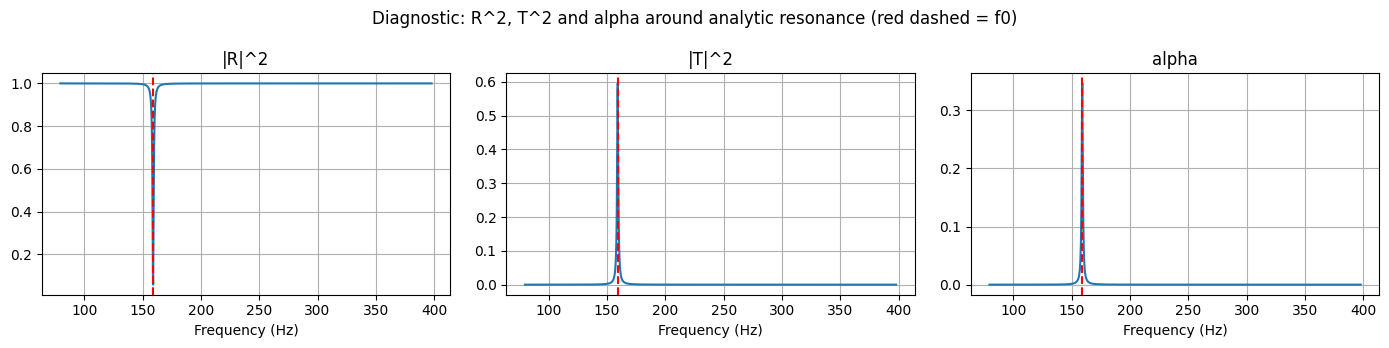

In [2]:
# -------- Diagnostic: energy balance at analytic resonance and local plot --------
# Exécutez ceci après avoir défini les fonctions et/ou après avoir lancé l'UI.

# read current widget values 
r_neck = r_w.value / 100.0        # m
L_neck = L_w.value / 100.0        # m
V_cav  = V_w.value / 1000.0       # m^3
R0_val = R0_w.value
Rscale_val = Rscale_w.value
fmax_plot = fmax_w.value

# derived
A_neck = np.pi * r_neck**2
f0 = helmholtz_resonance(A_neck, V_cav, L_neck, r_neck)

# compute Zs at f0 and neighbouring frequencies
f_vec = np.array([max(1.0, f0*0.999), f0, f0*1.001])  # tiny window
Zs_vec = helmholtz_impedance(f_vec, A_neck, V_cav, L_neck, r_neck, R0=R0_val, Rscale=Rscale_val)
R_amp_vec, T_amp_vec, alpha_vec, TL_vec = sheet_RT_alpha_TL(Zs_vec)

print("=== Diagnostic at analytic f0 (approx) ===")
print(f"Analytic f0 = {f0:.2f} Hz")
print(f"Zs at f0 = {Zs_vec[1]:.3e} (Pa·s/m)  -> Re(Zs) = {Zs_vec[1].real:.3e}, Im(Zs) = {Zs_vec[1].imag:.3e}")
print(f"R_amp @ f0 = {R_amp_vec[1]:.3e}  -> |R|^2 = {np.abs(R_amp_vec[1])**2:.4f}")
print(f"T_amp @ f0 = {T_amp_vec[1]:.3e}  -> |T|^2 = {np.abs(T_amp_vec[1])**2:.4f}")
print(f"alpha @ f0 = {alpha_vec[1]:.4f}")
print(f"TL @ f0 = {TL_vec[1]:.3f} dB")

# energy check around f0
energy_sum = np.abs(np.abs(R_amp_vec)**2 + np.abs(T_amp_vec)**2 + alpha_vec)
print("\nEnergy sums around f0 (should be ≈ 1):", np.round(energy_sum, 6))

# quick plot around resonance for visualization
f_plot = np.linspace(max(1, f0*0.5), min(fmax_plot, f0*2.5), 1500)
Zs_all = helmholtz_impedance(f_plot, A_neck, V_cav, L_neck, r_neck, R0=R0_val, Rscale=Rscale_val)
R_amp_all, T_amp_all, alpha_all, TL_all = sheet_RT_alpha_TL(Zs_all)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(14,3.5))
ax[0].plot(f_plot, np.abs(R_amp_all)**2); ax[0].set_title("|R|^2"); ax[0].axvline(f0, color='r', ls='--'); ax[0].grid(True)
ax[1].plot(f_plot, np.abs(T_amp_all)**2); ax[1].set_title("|T|^2"); ax[1].axvline(f0, color='r', ls='--'); ax[1].grid(True)
ax[2].plot(f_plot, alpha_all); ax[2].set_title("alpha"); ax[2].axvline(f0, color='r', ls='--'); ax[2].grid(True)
for a in ax:
    a.set_xlabel("Frequency (Hz)")
plt.suptitle("Diagnostic: R^2, T^2 and alpha around analytic resonance (red dashed = f0)")
plt.tight_layout()
plt.show()
